In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier  , AdaBoostClassifier , GradientBoostingClassifier
from sklearn.metrics import precision_score , recall_score 
import xgboost as xgb 
import pandas as pd 
import sklearn.neighbors._base
from os import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest 
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2
sns.set_style('whitegrid')

In [2]:
def details(data_sent , comments = ''):
    if(comments):
        print(comments)
    sp = (data_sent.isna().sum().sum())/ data_sent.size
    print('________________________________________________')
    print('Sparsity in the data : {:.2f}'.format(sp))
    num_rows = data_sent.shape
    print('Data shape' , num_rows)
    #display(data_sent['class'].value_counts())
    print('Number of sources : ')
    cl = data_sent['class'].unique()
    for c in cl:
        num_src = len(data_sent[data_sent['class']==c]['src_id'].unique())
        num_obs = len(data_sent[data_sent['class']==c])
        print(c ,' \t ' , num_src , '\t' , num_obs)

In [3]:
from features import phot_flux , en_flux , hard, powlaw_fit , bb_fit , brems_fit , intra_obs_var , inter_ob_var , info_col , phot_flux_hilim , phot_flux_lolim , en_flux_hilim , en_flux_lolim

In [4]:
data_imp_v2 = pd.read_csv('imputed_data/old-data-all-at-once-imp.csv' , index_col='obs_id')

In [5]:
details(data_imp_v2)

________________________________________________
Sparsity in the data : 0.00
Data shape (1812, 58)
Number of sources : 
CV  	  60 	 994
PL  	  92 	 297
LX  	  58 	 521


In [6]:
data_id = data_imp_v2[info_col]
data_label = data_imp_v2['class']
data_val = data_imp_v2.drop(columns=['class']+info_col)
data_imp_norm = data_imp_v2.copy()
for c in data_val.columns.to_list():
    data_imp_norm.loc[:,c] = (data_imp_norm.loc[:,c] - data_imp_norm.loc[:,c].mean()) / data_imp_norm.loc[:,c].std()
data_imp_norm

,src_id,num_obs,src_n,name,ra,dec,livetime,significance,likelihood,class,...,var_prob_b,photflux_aper_s,var_inter_index_h,var_inter_index_m,flux_aper_lolim_m,photflux_aper_lolim_m,flux_aper_s,photflux_aper_lolim_s,flux_aper_lolim_s,var_inter_index_s
obs_id,,,,,,,,,,,,,,,,,,,,,
CV_0_obs_0,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,4903.5,11.31,304.46460,CV,...,-0.199756,0.655713,-0.631091,-0.105345,0.290384,0.214930,0.696829,0.475032,0.511814,-0.504025
CV_0_obs_1,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3974.2,11.31,304.46460,CV,...,0.846163,0.340027,-0.328566,-0.340240,0.229157,0.145562,0.455051,0.574090,0.628355,-0.475066
CV_0_obs_2,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3907.5,11.31,304.46460,CV,...,0.532613,0.119252,-0.348735,-0.255417,0.365590,0.296245,0.060531,1.119369,1.050563,-0.475066
CV_0_obs_3,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3907.5,11.31,304.46460,CV,...,0.701297,0.473081,-0.342012,-0.248892,0.370397,0.295653,0.513148,0.709489,0.717932,-0.480858
CV_0_obs_4,CV_0,33,[HPH2013]_176__________,2CXO J004245.0+411520,10.68773,41.255820,3907.5,11.31,304.46460,CV,...,0.812733,0.487160,-0.328566,-0.261942,0.268815,0.174968,0.511412,0.664852,0.770695,-0.475066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LMXB_86_obs_0,LMXB_86,1,SAX_J1810.8-2609_____,2CXO J181044.4-260901,272.68530,-26.150370,31871.5,9.29,512.97550,LX,...,-1.342734,-0.458230,-0.664705,-0.359815,-0.197905,-0.220373,-0.356363,-0.682126,-0.582366,-0.353440
LMXB_90_obs_0,LMXB_90,1,XTE_J2123-058________,2CXO J212314.5-054753,320.81060,-5.798128,17705.1,4.06,132.76700,LX,...,1.732372,0.032560,-0.671428,-0.327190,1.133357,1.175422,0.020873,-0.149931,-0.157346,-0.347648
LMXB_91_obs_0,LMXB_91,1,XB_1732-304__________,2CXO J173547.0-302858,263.94590,-30.482820,18855.8,4.89,114.24570,LX,...,0.218212,0.929292,-2.015982,-0.392439,-0.289868,-0.269120,0.983880,1.147295,1.193074,-1.193241


In [7]:
details(data_imp_v2)

________________________________________________
Sparsity in the data : 0.00
Data shape (1812, 58)
Number of sources : 
CV  	  60 	 994
PL  	  92 	 297
LX  	  58 	 521


In [20]:
verbose = 0
val_acc = []
test_acc = []
for i in tqdm(range(32)):
    src_list = pd.DataFrame()
    class_to_select = ['CV' , 'LX' , 'PL']
    df = data_imp_norm.copy()
    for cl in class_to_select:
        src = df[df['class']==cl]['src_id'].value_counts().sort_values()
        #display(src)
        src = src.iloc[:int(len(src)*0.4)]
        src_select = src.sample(frac=0.5)
        src_id = src_select.index.to_list()
        src_obs = src_select.to_list()
        temp_src = pd.DataFrame({ 
            'src_id' : src_id , 
            'obs_count' : src_obs
        })
        src_list = src_list.append(temp_src)
    #src_list

    all_src = np.unique(df['src_id'].to_list())
    test_src = src_list['src_id'].to_list()
    train_src= list(set(all_src) - set(src_list['src_id']))
    # if(verbose):
    #     print('Total Number of ssources :' , len(all_src))
    #     print('Training_sources : ' , len(train_src) )
    #     print('Validation sources :' , len(test_src))

    # df = df.replace({
    #     "BH" :2 , 
    #     "NS" : 2 ,
    #     "CV" : 0 , 
    #     "PULSAR" : 1 
    # })


    df= df[df['class'].isin(class_to_select)]
    df 



    df_train  = df[df['src_id'].isin(train_src)]
    df_test = df[df['src_id'].isin(test_src)]

    df_train = df_train[df_train['class'].isin(class_to_select)]
    df_test = df_test[df_test['class'].isin(class_to_select)]

    if(verbose):
        details(df_train)
        details(df_test)

    train_id = df_train[info_col]
    train_label = df_train['class']
    train_value = df_train.drop(columns=['class']+info_col)


    i_val = df_test[info_col]
    y_val = df_test['class']
    x_val = df_test.drop(columns=['class']+info_col)

    clf = RandomForestClassifier(
        n_estimators = 200 , n_jobs=-1
    )
    #clf = AdaBoostClassifier(base_estimator=clf ,)
    #clf = xgb.XGBRFClassifier(n_componets=200)
    x_train , x_test , y_train , y_test = train_test_split(train_value , train_label , test_size=0.2 , stratify=train_label, random_state=9)
    clf.fit(x_train , y_train)
    v_sc = clf.score(x_val , y_val)
    test_sc = clf.score(x_test, y_test)
    val_acc.append(v_sc)
    test_acc.append(test_sc)
    #if(verbose):
    print(v_sc)

  3%|▎         | 1/32 [00:00<00:26,  1.17it/s]

0.6521739130434783


  6%|▋         | 2/32 [00:02<00:33,  1.11s/it]

0.581081081081081


  9%|▉         | 3/32 [00:03<00:30,  1.05s/it]

0.5138888888888888


 12%|█▎        | 4/32 [00:03<00:27,  1.03it/s]

0.5769230769230769


 16%|█▌        | 5/32 [00:04<00:26,  1.03it/s]

0.48484848484848486


 19%|█▉        | 6/32 [00:05<00:23,  1.12it/s]

0.5483870967741935


 22%|██▏       | 7/32 [00:06<00:22,  1.11it/s]

0.6911764705882353


 25%|██▌       | 8/32 [00:07<00:21,  1.12it/s]

0.5441176470588235


 28%|██▊       | 9/32 [00:08<00:22,  1.02it/s]

0.582089552238806


 31%|███▏      | 10/32 [00:09<00:22,  1.03s/it]

0.5151515151515151


 34%|███▍      | 11/32 [00:10<00:20,  1.02it/s]

0.5


 38%|███▊      | 12/32 [00:11<00:19,  1.02it/s]

0.6086956521739131


 41%|████      | 13/32 [00:12<00:18,  1.02it/s]

0.546875


 44%|████▍     | 14/32 [00:13<00:18,  1.01s/it]

0.5454545454545454


 47%|████▋     | 15/32 [00:14<00:17,  1.04s/it]

0.5774647887323944


 50%|█████     | 16/32 [00:15<00:16,  1.02s/it]

0.618421052631579


 53%|█████▎    | 17/32 [00:16<00:15,  1.04s/it]

0.7205882352941176


 56%|█████▋    | 18/32 [00:17<00:13,  1.01it/s]

0.5151515151515151


 59%|█████▉    | 19/32 [00:18<00:12,  1.06it/s]

0.6949152542372882


 62%|██████▎   | 20/32 [00:19<00:11,  1.05it/s]

0.5084745762711864


 66%|██████▌   | 21/32 [00:20<00:11,  1.00s/it]

0.6


 69%|██████▉   | 22/32 [00:21<00:10,  1.06s/it]

0.703125


 72%|███████▏  | 23/32 [00:22<00:09,  1.00s/it]

0.55


 75%|███████▌  | 24/32 [00:23<00:08,  1.00s/it]

0.6515151515151515


 78%|███████▊  | 25/32 [00:24<00:07,  1.05s/it]

0.5405405405405406


 81%|████████▏ | 26/32 [00:25<00:05,  1.00it/s]

0.5671641791044776


 84%|████████▍ | 27/32 [00:26<00:04,  1.01it/s]

0.5285714285714286


 88%|████████▊ | 28/32 [00:27<00:03,  1.02it/s]

0.6129032258064516


 91%|█████████ | 29/32 [00:28<00:03,  1.05s/it]

0.631578947368421


 94%|█████████▍| 30/32 [00:29<00:01,  1.04it/s]

0.717948717948718


 97%|█████████▋| 31/32 [00:30<00:01,  1.03s/it]

0.5641025641025641


100%|██████████| 32/32 [00:31<00:00,  1.00it/s]

0.5897435897435898


In [21]:
score = pd.DataFrame({
    "Test Score" : test_acc, 
    "Validation Score" : val_acc
})*100
score.describe().loc[['mean' , 'std' , 'min', 'max' ]]

,Test Score,Validation Score
mean,90.584243,58.697099
std,1.167260,6.679190
min,87.965616,48.484848
max,93.103448,72.058824


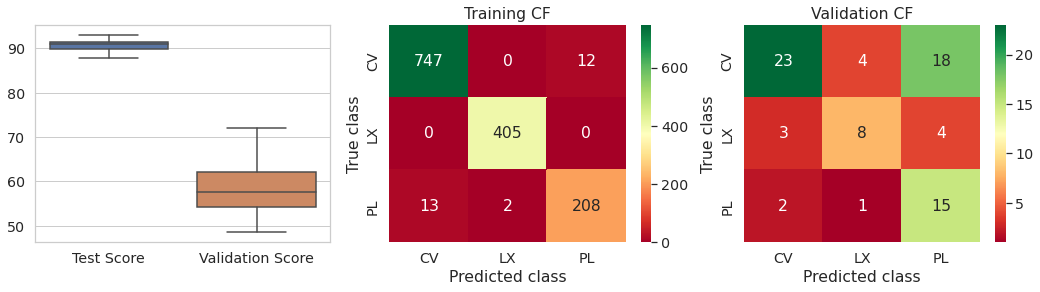

In [22]:
sns.set(font_scale=1.3)
sns.set_style('whitegrid')
fig , ax = plt.subplots(nrows=1 , ncols=3 , figsize = (18 , 4))
sns.boxplot(data = score , ax = ax[0])
cf = confusion_matrix(y_train , clf.predict(x_train) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[1] , xticklabels =class_to_select , yticklabels = class_to_select  , cmap='RdYlGn' ,)
cf = confusion_matrix(y_val , clf.predict(x_val) ,)
sns.heatmap(cf , annot=True ,fmt = '.0f' , ax = ax[2] , xticklabels=class_to_select, yticklabels = class_to_select , cmap='RdYlGn')
ax[1].set_title('Training CF')
ax[2].set_title('Validation CF')
for a in ax[1:]:
    a.set_xlabel('Predicted class')
    a.set_ylabel('True class')

plt.show()
#score